In [2]:
import pandas as pd
import numpy as np
import pickle
import json
import glob
import math
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import time
import random
from datetime import datetime, timedelta 
from itertools import permutations 
import os
import requests
import sklearn
from pandas.tseries.offsets import MonthEnd, MonthBegin
from dateutil import relativedelta
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
#sudo python3 -m pip install pandas

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 40)
plt.rc('figure', figsize=(18, 3))

In [3]:
# Download data, if not yet in directory
for filename in ['mnist_train.csv', 'mnist_test.csv']:
    if os.path.exists(filename):
        continue
    resp = requests.get(f'https://www.python-course.eu/data/mnist/{filename}')
    if resp.ok:
        with open(filename, mode='wb') as handle:
            handle.write(resp.content)
    else:
        print(f"LINK FAILED: {url}")

In [14]:
raw_data_test = pd.read_csv('mnist_test.csv', header=None)
raw_data_train = pd.read_csv('mnist_train.csv', header=None)

In [15]:
response_test = np.eye(10)[raw_data_test.iloc[0:,0]].astype(int) #one hot encode the response vector
data_test = np.array(raw_data_test.iloc[0:,1:])/255

response_training = np.eye(10)[raw_data_train.iloc[0:,0]].astype(int) #one hot encode the response vector
data_training = np.array(raw_data_train.iloc[0:,1:])/255

num_input_layer = data_test.shape[1]

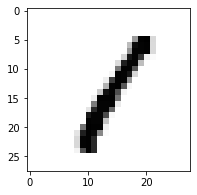

In [ ]:
from matplotlib.pyplot import imshow
img_data = raw_data_train.iloc[3, 1:].values.reshape((28, 28))
imshow(img_data, cmap='Greys')

In [ ]:
#activation functions
def relu(x):
    return x if x >= 0 else 0

def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

def cost(y, a):
    return 0.5 / y.shape[0] * ((y - a)**2).sum()

def cost_derivative_wrt_a(y, a):
    return a - y

def export_linear(x, weight, bias):
    z = x @ weight + bias #can change this to a RELU function instead too
    return sigmoid(z)

#np.multiple is component-wise multiplication i.e. [2,3] * [3,6] = [6,18]
#modelling a neuron dimensions: x * y ==> input dim * output dim
class Linear():
    def __init__(self, input_dim, output_dim):
        self.weight = np.random.randn(input_dim, output_dim) #dimensions
        self.bias = np.random.randn(output_dim) #dimensions
    
    def __call__(self, x):
        self.z = x @ self.weight+ self.bias #can change this to a RELU function instead too
        return sigmoid(self.z)

class MLP():
    def __init__(self, hidden_layers, dim_neurons):       
        self.hidden_layers = hidden_layers
        self.dim_neurons = dim_neurons
        self.fc_dim = [dim_neurons] * hidden_layers #creates a table specifying the number of neurons in each layer

        #Initialise Linear layers
        self.fc = []
        fc_input = Linear(num_input_layer, self.fc_dim[0]) #Create first feedforward layer
        self.fc.append(fc_input)

        for i in range(0, self.hidden_layers): #Create additional hidden layers
            self.fc.append(Linear(self.fc_dim[i-1], self.fc_dim[i])) 
        fc_output = Linear(self.fc_dim[self.hidden_layers-1], response_test.shape[1]) #Create output layer
        
        self.fc.append(fc_output)
    
    def forward(self, x):

        #forward pass
        for i in range(0, len(self.fc)):
            x = self.fc[i](x) #loop through all the linear hidden layers
        self.x_L = x
        return self.x_L


    def backprop(self, x, y):
        #number of layers in the neural net, excluding the input layer
        self.L = len(self.fc)

        #feedforward
        self.forward(x)

        #create output error
        self.fc[-1].delta = cost_derivative_wrt_a(y, self.x_L) * sigmoid_derivative(self.fc[-1].z) 
        
        #backpropagate the error
        for i in range(self.L - 1, 0, -1):
            self.fc[i-1].delta = (self.fc[i].delta @ self.fc[i].weight.T) * sigmoid_derivative(self.fc[i-1].z)
        
        #calculate nablas for gradient descent
        for i in range(self.L, 1, -1):
            self.fc[i-1].nabla_weight = (sigmoid(self.fc[i-2].z).T @ self.fc[i-1].delta)
            self.fc[i-1].nabla_bias = self.fc[i-1].delta.sum(axis=0)     

        self.fc[0].nabla_weight = (x.T @ self.fc[0].delta)
        self.fc[0].nabla_bias = self.fc[0].delta.sum(axis=0)  
   

    def update_mini_batch(self, mini_batch, learning_rate):
        #update weights and biases for a mini batch sample
        y = np.eye(10)[mini_batch.iloc[0:,0]].astype(int) #one hot encode the response vector
        x = np.array(mini_batch.iloc[0:,1:])/255
 
        m_size = x.shape[0]

        self.backprop(x,y)

        for i in range(self.L, 0, -1):
            self.fc[i-1].weight = self.fc[i-1].weight - (learning_rate/m_size) * self.fc[i-1].nabla_weight 
            self.fc[i-1].bias = self.fc[i-1].bias - (learning_rate/m_size) * self.fc[i-1].nabla_bias

    def evaluate(self, x, y):
        prediction = np.argmax(self.forward(x), axis=1)
        response = np.argmax(y, axis=1)
        return (prediction == response).mean()
        
    def SGD(self, training, epochs, mini_batch_size, learning_rate):
        #x is training_data
        n_size = training.shape[0] #10,000 training data

        for j in list(range(epochs)):
            shuffle_training = sklearn.utils.shuffle(training) 
            mini_batches = [shuffle_training[k:k+mini_batch_size] for k in list(range(0, n_size, mini_batch_size))] #place into mini matches
            
            for i in mini_batches:
                self.update_mini_batch(i, learning_rate)
            
            y = np.eye(10)[training.iloc[0:,0]].astype(int) #one hot encode the response vector
            x = np.array(training.iloc[0:,1:])/255

            print(f'Epoch {j} Completed - Accuracy {self.evaluate(data_training,response_training)}')



In [ ]:
np.random.seed(420)
nn = MLP(3,16)
nn.SGD(raw_data_train, epochs = 10, mini_batch_size = 100, learning_rate = 8)


Epoch 0 Completed - Accuracy 0.72095
Epoch 1 Completed - Accuracy 0.8021
Epoch 2 Completed - Accuracy 0.8146333333333333
Epoch 3 Completed - Accuracy 0.9109
Epoch 4 Completed - Accuracy 0.9182
Epoch 5 Completed - Accuracy 0.9254
Epoch 6 Completed - Accuracy 0.9213666666666667
Epoch 7 Completed - Accuracy 0.9213166666666667
Epoch 8 Completed - Accuracy 0.93735
Epoch 9 Completed - Accuracy 0.9368166666666666


In [ ]:
print(f'Mean {sigmoid(nn.fc[0].z).mean()}, Std {sigmoid(nn.fc[0].z).std()}')
print(f'Min {sigmoid(nn.fc[0].z).min()}, Max {sigmoid(nn.fc[0].z).max()}')

Mean 0.6099118266889682, Std 0.45064467807322184
Min 1.8182796653574744e-11, Max 0.9999999999999696


In [ ]:
nn.evaluate(data_test, response_test)

0.9279

In [ ]:
import pickle
import numpy as np

def export_linear(x, weight, bias):
    z = x @ weight + bias #can change this to a RELU function instead too
    return sigmoid(z)

def sigmoid(x):
    return 1/(1+np.exp(-x))

#weights
model_weights = pickle.load( open( "model_weights.pickle", "rb" ))

fc0_weight = model_weights[0]
fc1_weight = model_weights[1]
fc2_weight = model_weights[2]
fc3_weight = model_weights[3]
fc4_weight = model_weights[4]
fc0_bias = model_weights[5]
fc1_bias = model_weights[6]
fc2_bias = model_weights[7]
fc3_bias = model_weights[8]
fc4_bias = model_weights[9]


#input_string = str(np.array(raw_data_test.iloc[0,1:]).tolist()) #string input '[1, 2, ..., 3]' 784 elements
x = np.fromstring(input_string[1:-1],sep=',').astype(int)/255
x = export_linear(x, fc0_weight, fc0_bias) 
x = export_linear(x, fc1_weight, fc1_bias)
x = export_linear(x, fc2_weight, fc2_bias)
x = export_linear(x, fc3_weight, fc3_bias)
x = export_linear(x, fc4_weight, fc4_bias)
prediction = np.argmax(x)
prediction

7

In [ ]:
# ------- Steps
# install numpy on AWS
# use a numpy function on AWS
# export weights and biases onto a notebook
# input a test string into said model
# input data of weights and biases into AWS
# get lambda to read said data
# convert string input into numpy


In [ ]:
pickle_weights = [nn.fc[0].weight, nn.fc[1].weight, nn.fc[2].weight, nn.fc[3].weight, nn.fc[4].weight, nn.fc[0].bias, nn.fc[1].bias, nn.fc[2].bias, nn.fc[3].bias, nn.fc[4].bias]
pickle.dump(pickle_test, open( "model_weights.pickle", "wb"))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 84, 185, 159, 151, 60, 36, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 222, 254, 254, 254, 254, 241, 198, 198, 198, 198, 198, 198, 198, 198, 170, 52, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 67, 114, 72, 114, 163, 227, 254, 225, 254, 254, 254, 250, 229, 254, 254, 140, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17, 66, 14, 67, 67, 67, 59, 21, 236, 254, 106, 0, 0, 0, 

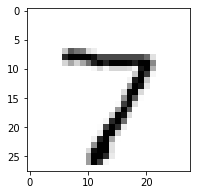

In [18]:
raw = raw_data_test.iloc[0,1:]

from matplotlib.pyplot import imshow
img_data = raw.values.reshape((28, 28))
imshow(img_data, cmap='Greys')
print(str(np.array(raw).tolist()))

In [ ]:
raw_data_test.iloc[0,1:]

TypeError: '(0, slice(1, None, None))' is an invalid key

In [10]:
input_string = '[2,3]'
x = np.fromstring(input_string[1:-1],sep=',')/255
x = np.array(x)/255
x

array([3.07574010e-05, 4.61361015e-05])

In [12]:
np.argmax(x)

1